In [1]:
import json
import os
from pathlib import Path

from os.path import join as pjoin

import numpy as np
import pytorch_lightning as pl
import torch
from rich.progress import track

from omegaconf import OmegaConf
from mld.data.utils import a2m_collate
from torch.utils.data import DataLoader
from mld.callback import ProgressLogger
from mld.config import parse_args
from mld.data.get_data import get_datasets
from mld.models.get_model import get_model
from mld.utils.logger import create_logger
import sklearn
from sklearn.manifold import TSNE
# from keras.datasets import mnist
from sklearn.datasets import load_iris
from numpy import reshape
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
cfg = parse_args(phase="test")  # parse config file
cfg.FOLDER = cfg.TEST.FOLDER
# create logger
logger = create_logger(cfg, phase="test")
output_dir = Path(
    os.path.join(cfg.FOLDER, str(cfg.model.model_type), str(cfg.NAME),
                    "latentspace_" + cfg.TIME))
output_dir.mkdir(parents=True, exist_ok=True)
logger.info(OmegaConf.to_yaml(cfg))

# set seed
pl.seed_everything(cfg.SEED_VALUE)

# gpu setting
if cfg.ACCELERATOR == "gpu":
    # os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(
    #     str(x) for x in cfg.DEVICE)
    os.environ["PYTHONWARNINGS"] = "ignore"
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

usage: ipykernel_launcher.py [-h] [--cfg CFG] [--cfg_assets CFG_ASSETS]
                             [--batch_size BATCH_SIZE]
                             [--device DEVICE [DEVICE ...]] [--nodebug]
                             [--dir DIR]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9003 --control=9001 --hb=9000 --Session.signature_scheme="hmac-sha256" --Session.key=b"91f23bc5-5ce8-434f-ad7e-b19cff79299b" --shell=9002 --transport="tcp" --iopub=9004 --f=/home/pjr726/.local/share/jupyter/runtime/kernel-v2-1256943hTDGOmcriXmC.json


SystemExit: 2

In [ ]:


# create dataset
dataset = get_datasets(cfg, logger=logger, phase="test")[0]
logger.info("datasets module {} initialized".format("".join(
    cfg.TRAIN.DATASETS)))
subset = 'train'.upper() 
split = eval(f"cfg.{subset}.SPLIT")
split_file = pjoin(
                eval(f"cfg.DATASET.{dataset.name.upper()}.SPLIT_ROOT"),
                eval(f"cfg.{subset}.SPLIT") + ".txt",
            )
dataloader = DataLoader(dataset.Dataset(split_file=split_file,split=split,**dataset.hparams),batch_size=8,collate_fn=a2m_collate)

# create model
model = get_model(cfg, dataset)
logger.info("model {} loaded".format(cfg.model.model_type))

# loading state dict
logger.info("Loading checkpoints from {}".format(cfg.TEST.CHECKPOINTS))

state_dict = torch.load(cfg.TEST.CHECKPOINTS,
                        map_location="cpu")["state_dict"]
model.load_state_dict(state_dict)
model = model.eval()

# Device
if cfg.ACCELERATOR == "gpu":
    device = torch.device("cuda")
    model = model.to(device)

# Generate latent codes
with torch.no_grad():
    labels = torch.tensor(np.array(list(range(0,dataset.nclasses)))).unsqueeze(1).to(device)
    lengths = torch.tensor([60]*dataset.nclasses).to(device)
    z_list = []
    for i in track(range(50),'Generating latent codes'):
        cond_emb = torch.cat((torch.zeros_like(labels), labels))
        # [steps, classes, latent_dim]
        z = model._diffusion_reverse_tsne(cond_emb, lengths)
        z_list.append(z)
    # [samples, steps, classes, latent_dim] -> [classes, samples, steps, latent_dim]
    latents = torch.stack(z_list, dim=0).permute(2,0,1,3).cpu().numpy()
    print(latents.shape)
    
# Draw figure
drawFig(output_dir, latents, classids = [8,6,5], steps = [0, 15, 35, 49])
logger.info("TSNE figure saved to {}".format(output_dir))


In [ ]:
def data_parse(step: int, latents: np.ndarray, classids: list):
    nsample = 30

    # classids = list(range(0,12))
    nclass = len(classids)
    # (12, 50, 50, 256)
    t_0 = latents[classids,:nsample, step,:]
    t_0 = t_0.reshape(-1, t_0.shape[-1])


    # labels = np.array(list(range(0,nclass)))
    # labels = labels.repeat(nsample)

    # labels = np.array(['sit', 'lift_dumbbell', 'turn_steering'])
    labels = np.array(['throw', 'walk', 'boxing'])
    labels = labels.repeat(nsample)
    # labels = [['sit']* nsample,['lift_dumbbell']* nsample, ['turn steering wheel']* nsample]
    # labels = labels * nsample

    tsne = TSNE(n_components=2, verbose=0, random_state=123)
    z = tsne.fit_transform(t_0) 
    df = pd.DataFrame()

    # normalize
    z = 1.8*(z-np.min(z,axis=0))/(np.max(z,axis=0)-np.min(z,axis=0)) -0.9

    df["y"] = labels
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]
    return df

In [ ]:
def drawFig(output_dir: str, latents: np.ndarray, classids: list = [8,6,5], steps: list = [0, 15, 35, 49] ):
    ''' 
    Draw the figure of t-SNE
    Parameters:
        output_dir: output directory
        latents: (12, 50, 50, 256)
        steps: list of diffusion steps to draw
        classids: list of class ids
            # 0: "warm_up",
            # 1: "walk",
            # 2: "run",
            # 3: "jump",
            # 4: "drink",
            # 5: "lift_dumbbell",
            # 6: "sit",
            # 7: "eat",
            # 8: "turn steering wheel",
            # 9: "phone",
            # 10: "boxing",
            # 11: "throw",
    '''

    sns.set()

    fig, axs = plt.subplots(1, 4, figsize=(4*3,2.5))

    nclass = len(classids)
    steps.sort(reverse=True)
    for i, step in enumerate(steps):
        df = data_parse(steps[0]-step,latents,classids)
        sns.scatterplot(ax=axs[i], x="comp-1", y="comp-2", hue='y',
                        legend = False if i != len(steps) -1  else True,
                        palette=sns.color_palette("hls", nclass),
                        data=df).set(title=r"t = {}".format(step)) 

        axs[i].set_xlim((-1, 1))
        axs[i].set_ylim((-1, 1))

    plt.legend(loc=[1.1,0.2], title='Action ID')

    plt.tight_layout()
    plt.savefig(pjoin(output_dir, 'TSNE.png'), bbox_inches='tight')
    plt.show()

In [ ]:
def main():
    # parse options
    cfg = parse_args(phase="test")  # parse config file
    cfg.FOLDER = cfg.TEST.FOLDER
    # create logger
    logger = create_logger(cfg, phase="test")
    output_dir = Path(
        os.path.join(cfg.FOLDER, str(cfg.model.model_type), str(cfg.NAME),
                     "tsne_" + cfg.TIME))
    output_dir.mkdir(parents=True, exist_ok=True)
    logger.info(OmegaConf.to_yaml(cfg))

    # set seed
    pl.seed_everything(cfg.SEED_VALUE)

    # gpu setting
    if cfg.ACCELERATOR == "gpu":
        # os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(
        #     str(x) for x in cfg.DEVICE)
        os.environ["PYTHONWARNINGS"] = "ignore"
        os.environ["TOKENIZERS_PARALLELISM"] = "false"

    # create dataset
    dataset = get_datasets(cfg, logger=logger, phase="test")[0]
    logger.info("datasets module {} initialized".format("".join(
        cfg.TRAIN.DATASETS)))
    subset = 'train'.upper() 
    split = eval(f"cfg.{subset}.SPLIT")
    split_file = pjoin(
                    eval(f"cfg.DATASET.{dataset.name.upper()}.SPLIT_ROOT"),
                    eval(f"cfg.{subset}.SPLIT") + ".txt",
                )
    dataloader = DataLoader(dataset.Dataset(split_file=split_file,split=split,**dataset.hparams),batch_size=8,collate_fn=a2m_collate)

    # create model
    model = get_model(cfg, dataset)
    logger.info("model {} loaded".format(cfg.model.model_type))

    # loading state dict
    logger.info("Loading checkpoints from {}".format(cfg.TEST.CHECKPOINTS))

    state_dict = torch.load(cfg.TEST.CHECKPOINTS,
                            map_location="cpu")["state_dict"]
    model.load_state_dict(state_dict)
    model = model.eval()
    
    # Device
    if cfg.ACCELERATOR == "gpu":
        device = torch.device("cuda")
        model = model.to(device)
    
    # Generate latent codes
    with torch.no_grad():
        labels = torch.tensor(np.array(list(range(0,dataset.nclasses)))).unsqueeze(1).to(device)
        lengths = torch.tensor([60]*dataset.nclasses).to(device)
        z_list = []
        for i in track(range(50),'Generating latent codes'):
            cond_emb = torch.cat((torch.zeros_like(labels), labels))
            # [steps, classes, latent_dim]
            z = model._diffusion_reverse_tsne(cond_emb, lengths)
            z_list.append(z)
        # [samples, steps, classes, latent_dim] -> [classes, samples, steps, latent_dim]
        latents = torch.stack(z_list, dim=0).permute(2,0,1,3).cpu().numpy()
        print(latents.shape)
        
    # Draw figure
    drawFig(output_dir, latents, classids = [8,6,5], steps = [0, 15, 35, 49])
    logger.info("TSNE figure saved to {}".format(output_dir))

if __name__ == "__main__":
    main()


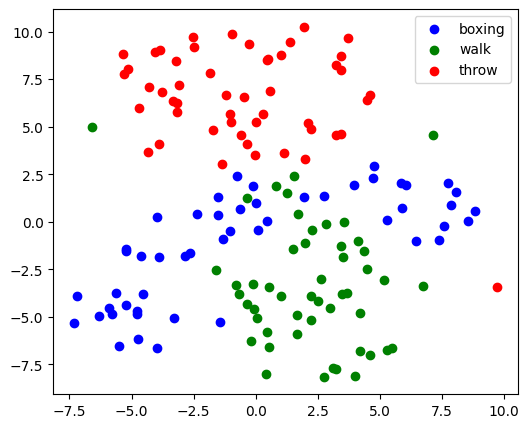

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Create a color dictionary for each action
color_dict = {
    'boxing': 'red',
    'walk': 'blue',
    'throw': 'green'
}

# Directory where .npy files are stored
directory = '/home/pjr726/motion-latent-diffusion/results/mld/latent_z'

# List to store data and labels
data = []
labels = []

# Read all .npy files
for filename in os.listdir(directory):
    if filename.endswith('.npy'):
        # Load the numpy array
        array = np.load(os.path.join(directory, filename))

        # Append the array and the label to the respective lists
        data.append(array)
        action = filename.split('_')[0]  # action name is the first part of the filename
        labels.append(action)

# Convert list to numpy array
data = np.array(data)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
data_2d = tsne.fit_transform(data)

# Plot
plt.figure(figsize=(6, 5))
for i, label in enumerate(labels):
    plt.scatter(data_2d[i, 0], data_2d[i, 1], color=color_dict[label])
plt.legend(color_dict.keys())
plt.show()


In [3]:
import os
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne_steps(folder_path, steps):
    # Define the color for each action
    colors = {"boxing": "red", "walk": "blue", "throw": "green"}  # Add more as needed
    file_list = os.listdir(folder_path)

    for step in steps:
        plt.figure(figsize=(10, 10))
        for file in file_list:
            if file.endswith(".npy"):
                action = file.split("_")[0]
                data = np.load(os.path.join(folder_path, file))
                data_step = data[step, :]
                tsne = TSNE(n_components=2, random_state=0)
                tsne_obj = tsne.fit_transform(data_step.reshape(1, -1))
                plt.scatter(tsne_obj[:, 0], tsne_obj[:, 1], color=colors[action])

        plt.title(f"t-SNE plot at timestep {step}")
        plt.show()

folder_path = "/home/pjr726/motion-latent-diffusion/results/mld/latent_z_all_steps"
steps = [0, 15, 35, 49]
plot_tsne_steps(folder_path, steps)


ValueError: perplexity must be less than n_samples

<Figure size 1000x1000 with 0 Axes>

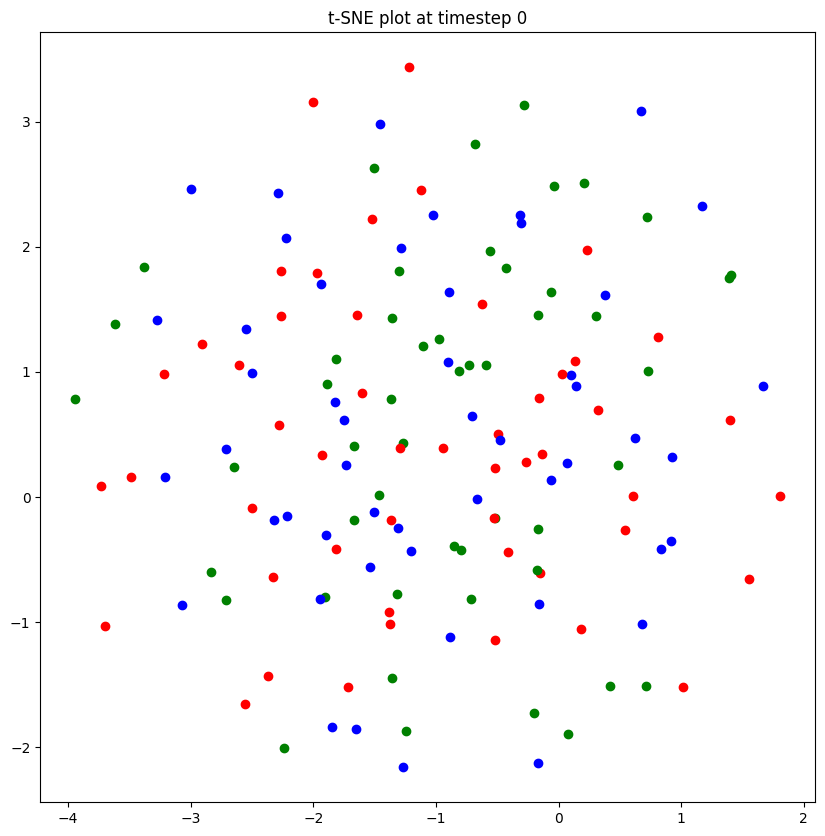

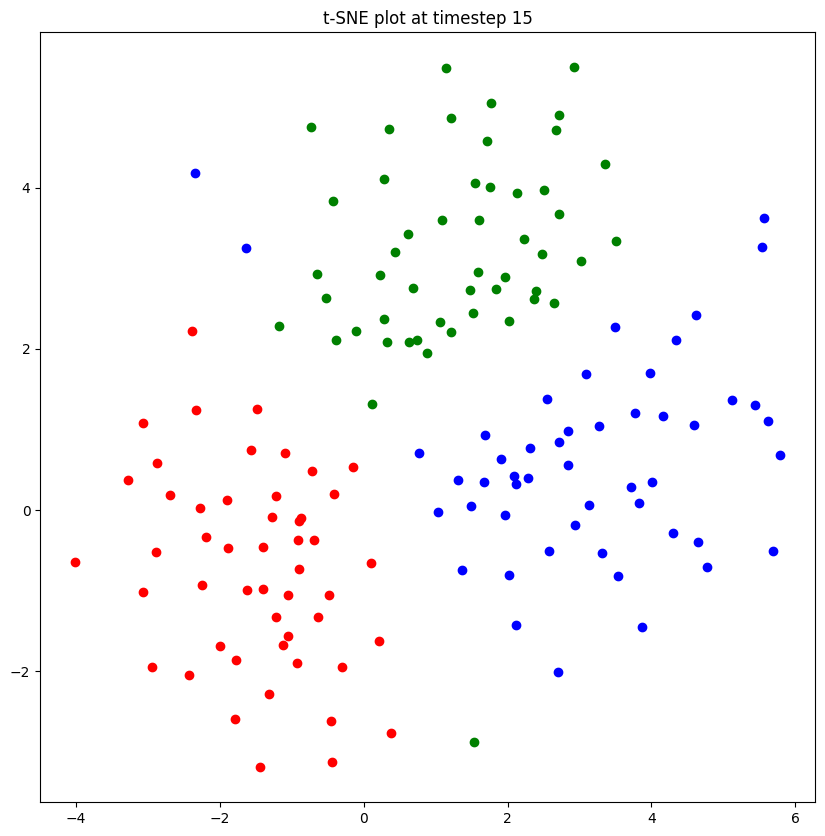

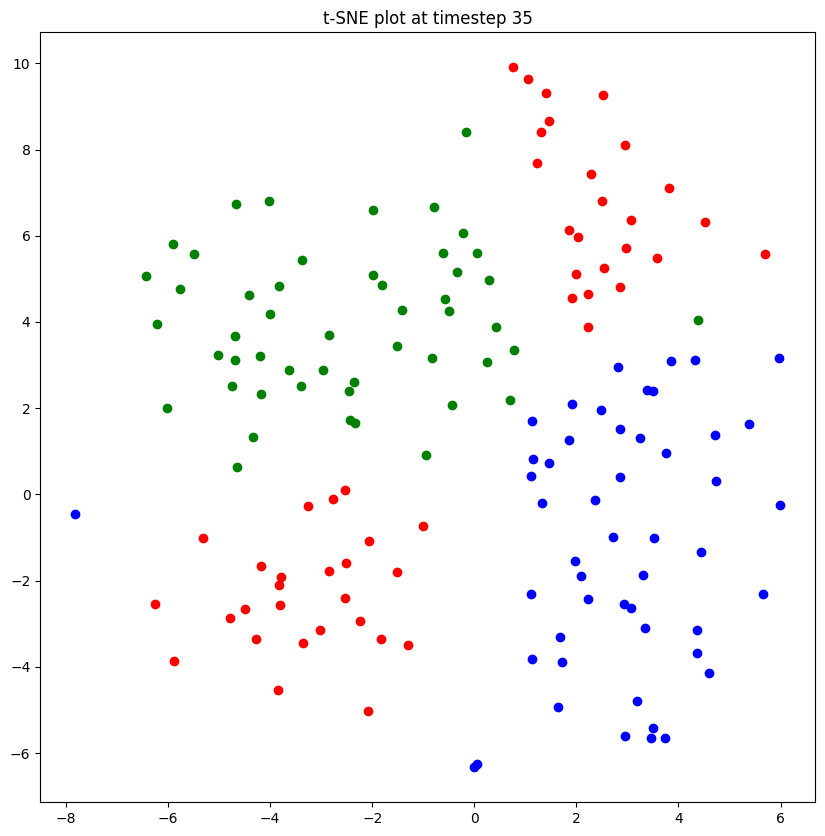

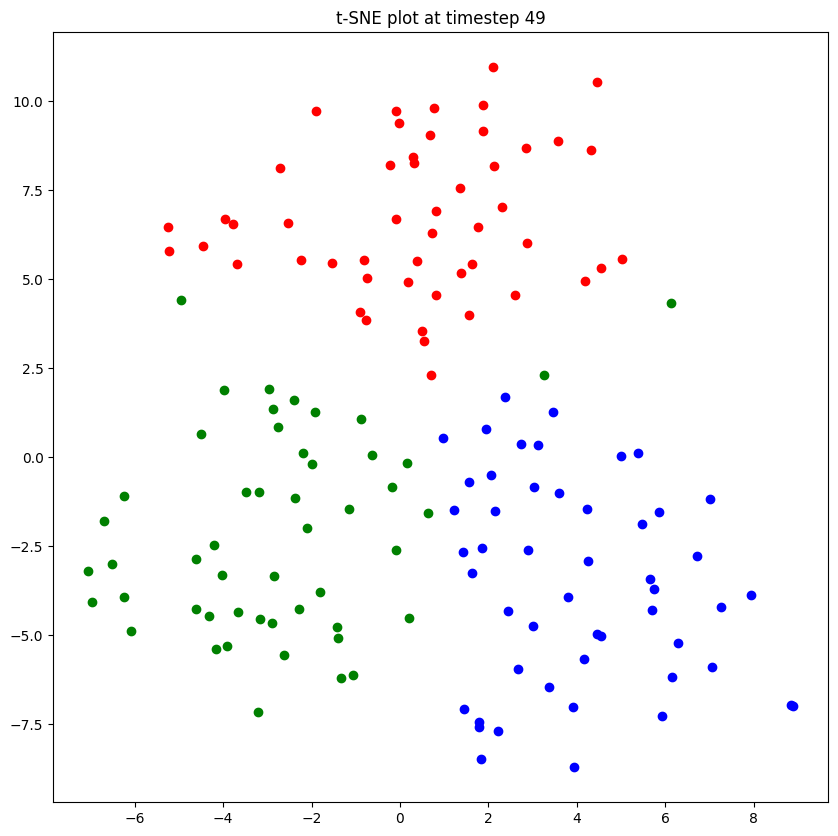

In [5]:
def plot_tsne_steps(folder_path, steps):
    # Define the color for each action
    colors = {"boxing": "red", "walk": "blue", "throw": "green"}  # Add more as needed
    file_list = os.listdir(folder_path)

    for step in steps:
        data_step_list = []
        labels = []
        for file in file_list:
            if file.endswith(".npy"):
                action = file.split("_")[0]
                data = np.load(os.path.join(folder_path, file))
                data_step = data[step, :]
                data_step_list.append(data_step)
                labels.append(action)

        # Perform t-SNE on all data at this step
        tsne = TSNE(n_components=2, random_state=0)
        tsne_obj = tsne.fit_transform(np.array(data_step_list))

        # Plot each point with color corresponding to its label
        plt.figure(figsize=(10, 10))
        for i in range(len(labels)):
            plt.scatter(tsne_obj[i, 0], tsne_obj[i, 1], color=colors[labels[i]])

        plt.title(f"t-SNE plot at timestep {step}")
        plt.show()

folder_path = "/home/pjr726/motion-latent-diffusion/results/mld/latent_z_all_steps"
steps = [0, 15, 35, 49]
plot_tsne_steps(folder_path, steps)


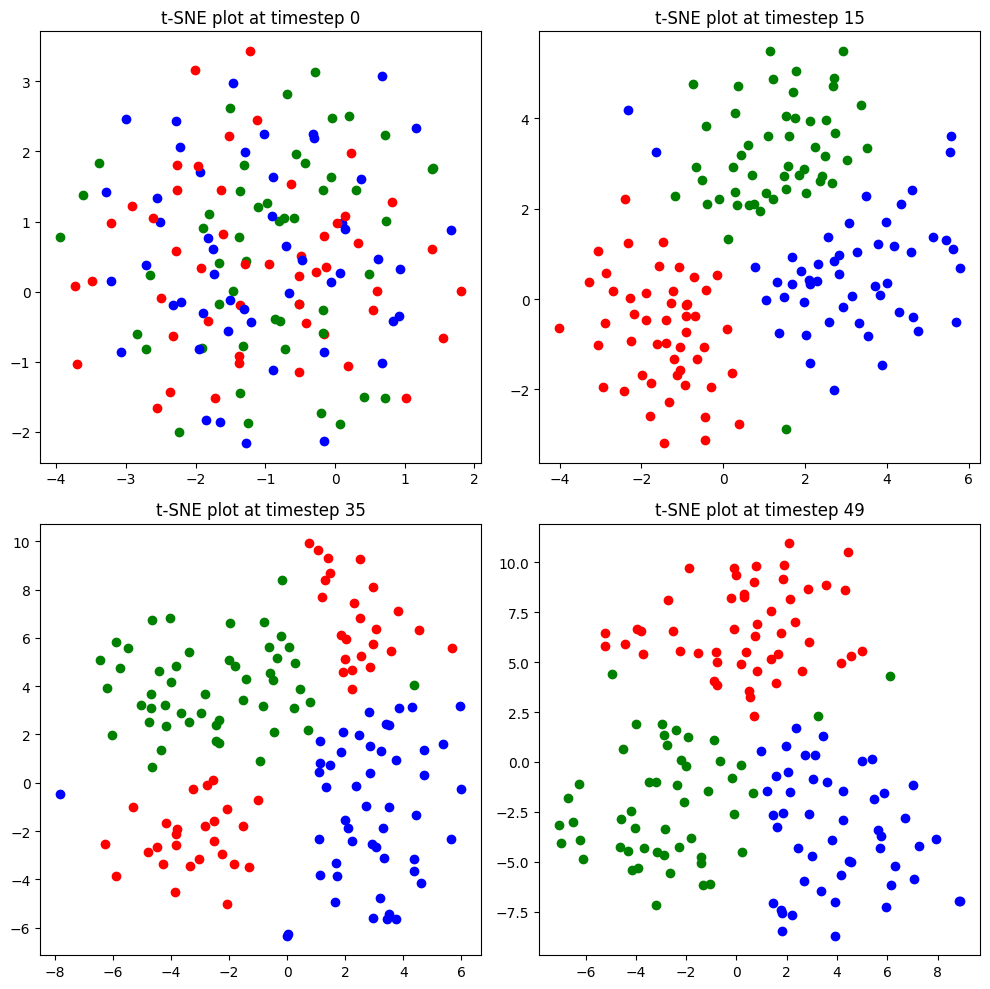

In [7]:
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.manifold import TSNE

def plot_tsne_steps(folder_path, steps):
    # Define the color for each action
    colors = {"boxing": "red", "walk": "blue", "throw": "green"}  # Add more as needed
    file_list = os.listdir(folder_path)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.ravel()

    for idx, step in enumerate(steps):
        data_step_list = []
        labels = []
        for file in file_list:
            if file.endswith(".npy"):
                action = file.split("_")[0]
                data = np.load(os.path.join(folder_path, file))
                data_step = data[step, :]
                data_step_list.append(data_step)
                labels.append(action)

        # Perform t-SNE on all data at this step
        tsne = TSNE(n_components=2, random_state=0)
        tsne_obj = tsne.fit_transform(np.array(data_step_list))

        # Plot each point with color corresponding to its label
        for i in range(len(labels)):
            axs[idx].scatter(tsne_obj[i, 0], tsne_obj[i, 1], color=colors[labels[i]])

        axs[idx].set_title(f"t-SNE plot at timestep {step}")

    plt.tight_layout()
    plt.show()

folder_path = "/home/pjr726/motion-latent-diffusion/results/mld/latent_z_all_steps"
steps = [0, 15, 35, 49]
plot_tsne_steps(folder_path, steps)


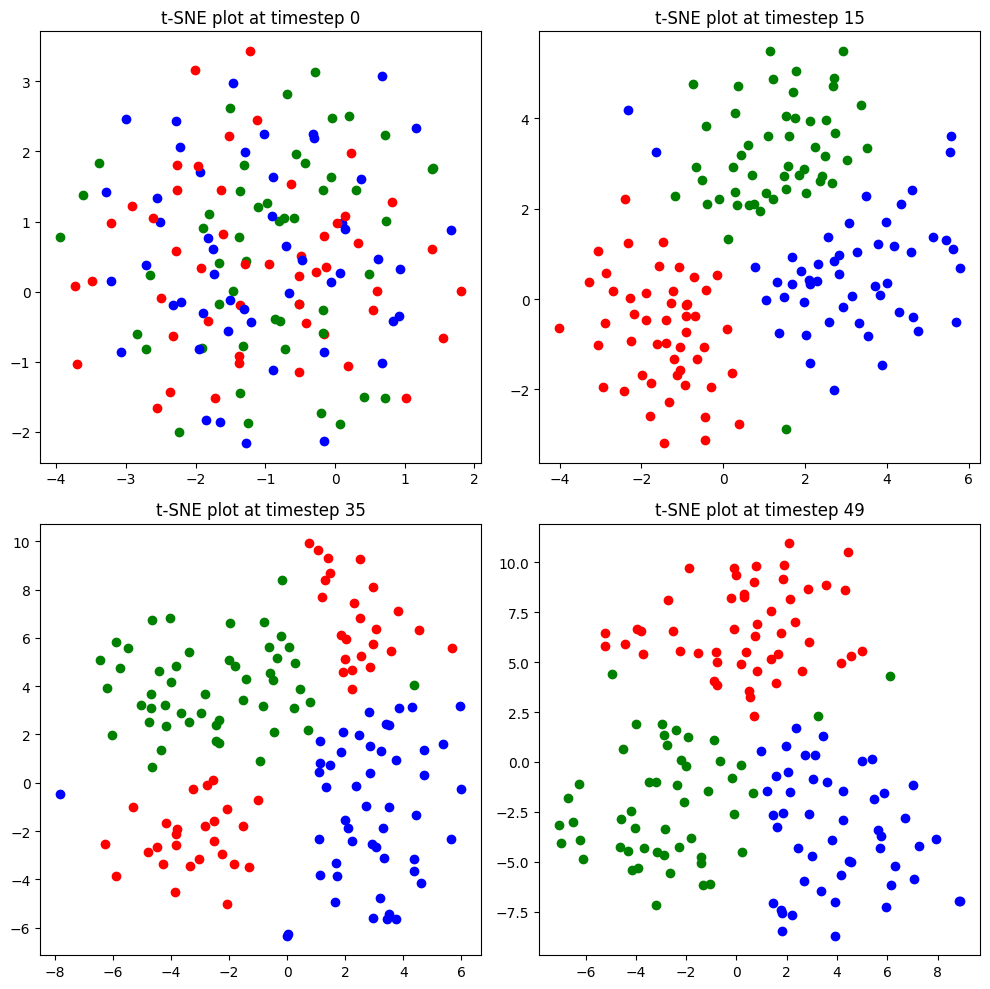

In [8]:
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.manifold import TSNE

def plot_tsne_steps(folder_path, steps, save_path):
    # Define the color for each action
    colors = {"boxing": "red", "walk": "blue", "throw": "green"}  # Add more as needed
    file_list = os.listdir(folder_path)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.ravel()

    for idx, step in enumerate(steps):
        data_step_list = []
        labels = []
        for file in file_list:
            if file.endswith(".npy"):
                action = file.split("_")[0]
                data = np.load(os.path.join(folder_path, file))
                data_step = data[step, :]
                data_step_list.append(data_step)
                labels.append(action)

        # Perform t-SNE on all data at this step
        tsne = TSNE(n_components=2, random_state=0)
        tsne_obj = tsne.fit_transform(np.array(data_step_list))

        # Plot each point with color corresponding to its label
        for i in range(len(labels)):
            axs[idx].scatter(tsne_obj[i, 0], tsne_obj[i, 1], color=colors[labels[i]])

        axs[idx].set_title(f"t-SNE plot at timestep {step}")

    plt.tight_layout()
    plt.savefig(save_path, format='pdf')  # Save the plot as a PDF
    plt.show()

folder_path = "/home/pjr726/motion-latent-diffusion/results/mld/latent_z_all_steps"
steps = [0, 15, 35, 49]
save_path = "/home/pjr726/motion-latent-diffusion/tsne_plot.pdf"  # Replace with the desired save path
plot_tsne_steps(folder_path, steps, save_path)


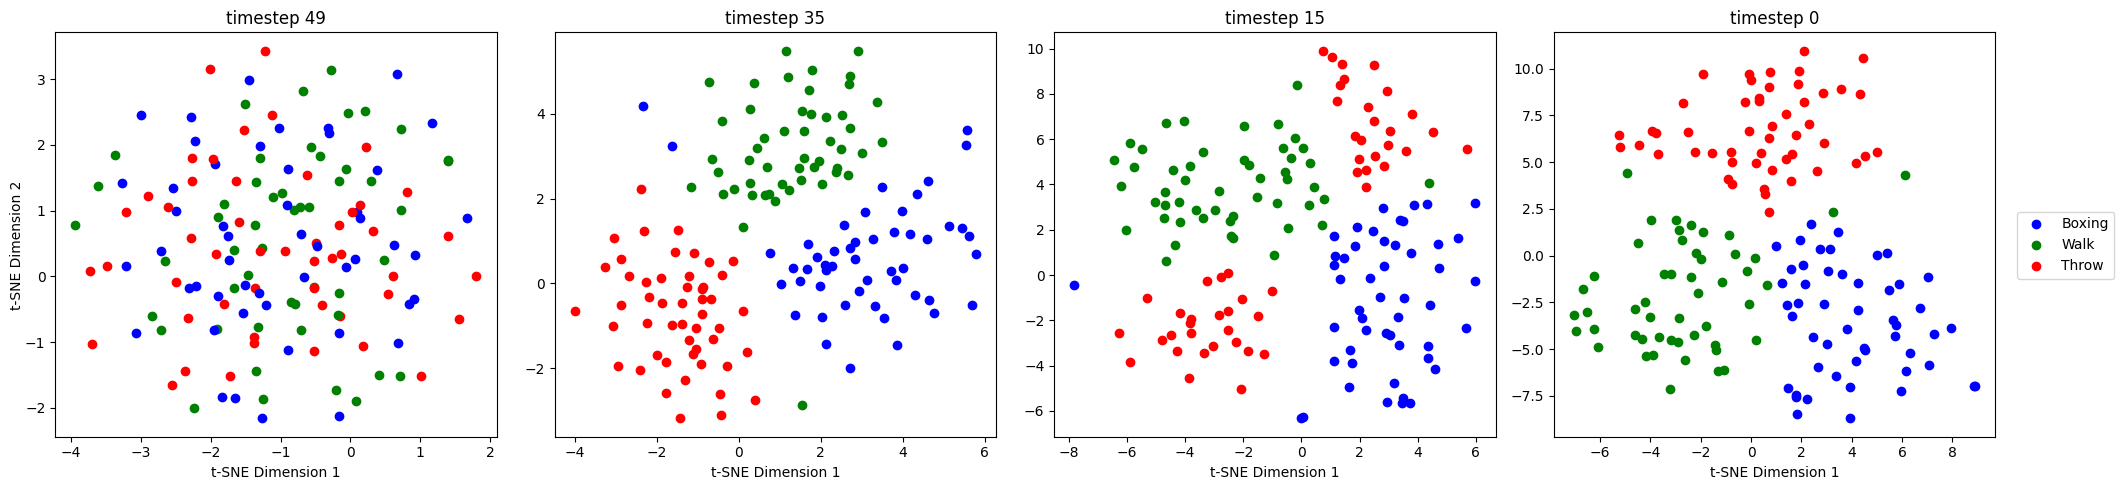

In [16]:
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.manifold import TSNE

def plot_tsne_steps(folder_path, steps, save_path):
    # Define the color for each action
    colors = {"boxing": "red", "walk": "blue", "throw": "green"}  # Add more as needed
    labels_legend = {"boxing": "Boxing", "walk": "Walk", "throw": "Throw"}  # For the legend
    file_list = os.listdir(folder_path)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Adjusted for horizontal layout
    lines = []  # To store the legend lines

    reversed_steps = steps[::-1]  # Reverse the steps list for titles

    for idx, step in enumerate(steps):
        data_step_list = []
        labels = []
        for file in file_list:
            if file.endswith(".npy"):
                action = file.split("_")[0]
                data = np.load(os.path.join(folder_path, file))
                data_step = data[step, :]
                data_step_list.append(data_step)
                labels.append(action)

        # Perform t-SNE on all data at this step
        tsne = TSNE(n_components=2, random_state=0)
        tsne_obj = tsne.fit_transform(np.array(data_step_list))

        # Plot each point with color corresponding to its label
        for i in range(len(labels)):
            scatter = axs[idx].scatter(tsne_obj[i, 0], tsne_obj[i, 1], color=colors[labels[i]], label=labels_legend[labels[i]])
        
        # Remove duplicates in legend
        handles, labels = axs[idx].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        lines.extend(by_label.values())  # Add the legend lines

        axs[idx].set_title(f"timestep {reversed_steps[idx]}")  # Set title to the reversed step
        axs[idx].set_xlabel('t-SNE Dimension 1')  # Set the label for the x-axis

    # Set common labels
    fig.subplots_adjust(left=0.7)  # Make room for the y label
    fig.text(0, 0.5, 't-SNE Dimension 2', va='center', rotation='vertical')  # y_axis label
    fig.legend(lines, labels_legend.values(), bbox_to_anchor=(1, 0.5), loc='center left')  # Shared legend on the right


    plt.tight_layout()
    plt.savefig(save_path, format='pdf')  # Save the plot as a PDF
    plt.show()

folder_path = "/home/pjr726/motion-latent-diffusion/results/mld/latent_z_all_steps"
steps = [0, 15, 35, 49]
save_path = "/home/pjr726/motion-latent-diffusion/tsne_plot_row.pdf"  # Replace with the desired save path
plot_tsne_steps(folder_path, steps, save_path)


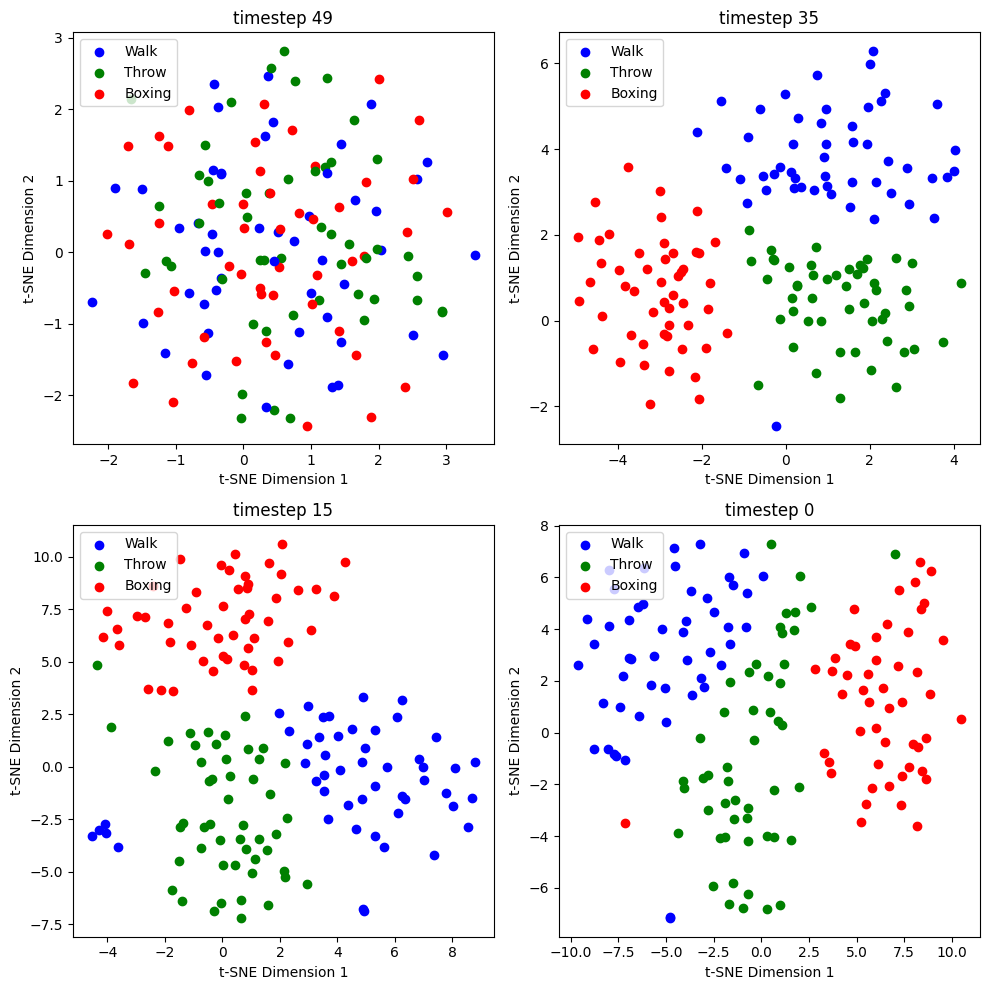

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.manifold import TSNE

def plot_tsne_steps(folder_path, steps, save_path):
    # Define the color for each action
    colors = {"boxing": "red", "walk": "blue", "throw": "green"}  # Add more as needed
    labels_legend = {"boxing": "Boxing", "walk": "Walk", "throw": "Throw"}  # For the legend
    file_list = os.listdir(folder_path)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Adjusted for 2x2 layout
    axs = axs.ravel()

    reversed_steps = steps[::-1]  # Reverse the steps list for titles

    for idx, step in enumerate(steps):
        data_step_list = []
        labels = []
        for file in file_list:
            if file.endswith(".npy"):
                action = file.split("_")[0]
                data = np.load(os.path.join(folder_path, file))
                data_step = data[step, :]
                data_step_list.append(data_step)
                labels.append(action)

        # Perform t-SNE on all data at this step
        tsne = TSNE(n_components=2, random_state=0)
        tsne_obj = tsne.fit_transform(np.array(data_step_list))

        # Plot each point with color corresponding to its label
        for i in range(len(labels)):
            scatter = axs[idx].scatter(tsne_obj[i, 0], tsne_obj[i, 1], color=colors[labels[i]], label=labels_legend[labels[i]])
        
        # Remove duplicates in legend
        handles, labels = axs[idx].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axs[idx].legend(by_label.values(), by_label.keys(), loc='upper left')  # Legend in upper left corner

        axs[idx].set_title(f"timestep {reversed_steps[idx]}")  # Set title to the reversed step
        axs[idx].set_xlabel('t-SNE Dimension 1')  # Set the label for the x-axis
        axs[idx].set_ylabel('t-SNE Dimension 2')  # Set the label for the y-axis

    plt.tight_layout()
    plt.savefig(save_path, format='pdf')  # Save the plot as a PDF
    plt.show()

folder_path = "/home/pjr726/motion-latent-diffusion/results/mld/latent_z_all_steps"
steps = [0, 15, 35, 49]
save_path = "/home/pjr726/motion-latent-diffusion/tsne_plot.pdf"  # Replace with the desired save path
plot_tsne_steps(folder_path, steps, save_path)
